In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from PIL import Image
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet152_Weights

from trainer import PTTrainer, HFTrainer

from transformers import (
    BitForImageClassification,
    BitImageProcessor,
    ViTForImageClassification,
    ViTImageProcessor,
)

from captum.attr import visualization as viz, LayerAttribution, LayerGradCam
#from transformers.models.bit.modeling_bit import BitForImageClassification

2024-01-15 02:20:45.482635: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 02:20:45.499936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 02:20:45.499956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 02:20:45.500429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 02:20:45.503769: I tensorflow/core/platform/cpu_feature_guar

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090 Ti'

In [3]:
train_folder = ImageFolder(root="train")
val_folder = ImageFolder(root="train")
test_set = ImageFolder(root="test")

train_set, val_set = torch.utils.data.random_split(train_folder, [0.9,0.1])
val_set.dataset = val_folder

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((1024, 1024), antialias=True),
    transforms.RandomRotation((-35, 35)), # First rotate then crop to remove black corners introduced by rotating the image
    transforms.CenterCrop(size=(900, 900)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=.2), # Some images are naturally darker, and some lighter. So augmenting the brightness improves results
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True), # Required size for all three models used
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Required pixel range for all three models
])
transform_val = transforms.Compose([
    transforms.Resize((1024, 1024),antialias=True),
    transforms.CenterCrop(size=(900, 900)),
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_set.dataset.transform=transform_train
val_set.dataset.transform=transform_val
test_set.transform=transform_val


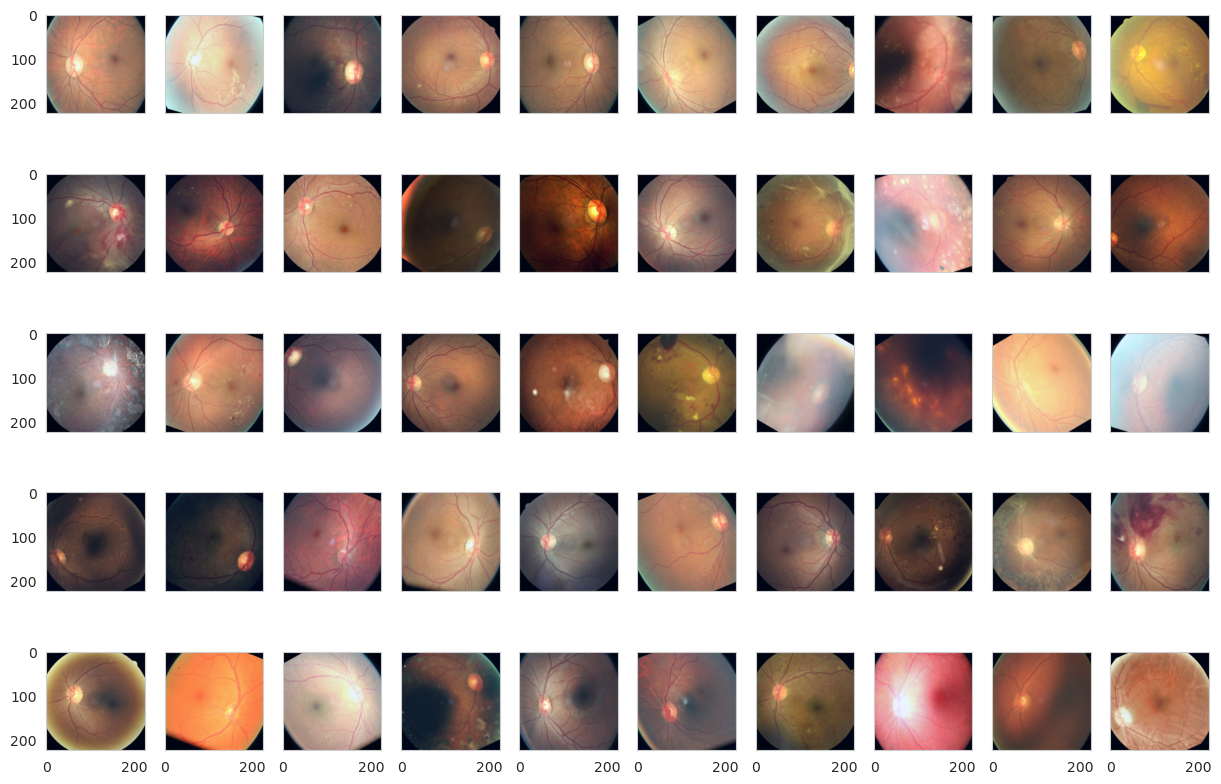

In [5]:
# Create a DataLoader
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
figs, axs = plt.subplots(5,10, figsize=(15, 10))

for col in range(1,10):
    for ax in axs[:, col]:
        ax.yaxis.set_ticklabels([])
        

# Set x-grid only for the lower subplots
for row in range(4):
    for ax in axs[row, :]:
        ax.xaxis.set_ticklabels([])
axs=axs.flatten()

for i, (inputs, labels) in enumerate(train_loader):
    if i < 1:
        for j in range(50):
            #bs, ncrops, c, h, w = inputs.size()
            
            #img = np.array(inputs.view(-1, c, h, w)[j].permute(1, 2, 0) )
            img = np.array(inputs[j].permute(1, 2, 0) )
            img = (img - img.min()) / (img.max() - img.min()) # Broadcasting rules apply
            axs[j].imshow(img)
            
    else:
        break
for ax in axs:
    ax.grid(False)
plt.show()

In [6]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(7, 7))
    axs = axs.flatten()
    for i, (set, metric) in enumerate([["Train", "accuracy"], ["Test", "accuracy"], ["Train", "loss"], ["Test", "loss"]]):
        if len(history[i]) > 0:
            axs[int(i/2)].plot(history[i], label=f"{set} {metric}")
        axs[int(i/2)].set_xlabel("Epoch")
        if int(i/2) == 0:
            axs[int(i/2)].set_ylabel("Accuracy")
        else:
            axs[int(i/2)].set_ylabel("Error")
        if len(history[i]) > 0:
            axs[int(i/2)].legend()
    plt.tight_layout()
    plt.show()

In [7]:
def plot_confusion_matrix(model_trainer, model_name):
    true_classes, pred_classes = model_trainer.validate(test_loader=test_loader, device="cuda")
    ax = sn.heatmap(metrics.confusion_matrix(true_classes, pred_classes), annot=True, cmap="Blues", fmt='g')
    ax.set(xlabel="True Class", ylabel="Predicted Class")
    ax.set_title(f"{model_name} \nAcc: {round(metrics.accuracy_score(true_classes, pred_classes), 2)}, F1: {round(metrics.f1_score(true_classes, pred_classes, average='macro'), 2)}", fontsize=20)
    plt.show()
    return true_classes, pred_classes

In [8]:
def plot_misclassified(true_classes, pred_classes):
    missclassified_ids = []
    for true_class in range(5):
        missclassified_ids.append(np.where(((np.array(true_classes)!=np.array(pred_classes)) & (np.array(true_classes) == true_class)) == True)[0][0])
    misclassified_imgs = np.array(test_set.imgs)[np.array(missclassified_ids)]
    misclassified_imgs = np.concatenate([misclassified_imgs, np.array(pred_classes)[missclassified_ids].reshape(-1,1)], axis=1)
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 7))
    for i, (path, true_class, pred_class) in enumerate(misclassified_imgs):
        # Load and plot the misclassified image
        img = Image.open(path)
        
        axs[i].imshow(img)
        axs[i].set_title(f'True: {true_class}\nPred: {pred_class}')
        axs[i].axis('off')
    plt.show()

In [9]:
def plot_attention_cnn(cnn_model, conv_layer_index):
    cnn_model = cnn_model.to("cpu")
    conv_layers = [module for module in cnn_model.modules() if isinstance(module, torch.nn.Conv2d)]
    target_layer = conv_layers[conv_layer_index]
    
    layer_gradcam = LayerGradCam(cnn_model, target_layer)
    
    for img_path in ["test/4/1084_right.jpeg", "test/3/1471_right.jpeg", "test/2/1527_left.jpeg", "test/1/1540_right.jpeg", "test/0/1070_left.jpeg"]:
        img = Image.open(img_path)
        img_transform = transform_val(img)
        attributions_lgc = layer_gradcam.attribute(img_transform.unsqueeze(0), target=[eval(img_path[5])])
        upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, img_transform.shape[1:])
        
        print("True class:", img_path[5])
        print("Predicted class:", int(torch.argmax(cnn_model(img_transform.unsqueeze(0)))))
        _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                              np.array(img.resize((224, 224))),
                                              ["original_image","heat_map","masked_image"],
                                              ["all","absolute_value","absolute_value"],
                                              show_colorbar=True,
                                              titles=["Original","Heat Map",  "Masked"],
                                              fig_size=(18, 6), cmap="RdBu_r")

In [10]:
def plot_attention_vit(vit_model, layer=-1, head=0, mask_threshold=0.01):
    for img_path in ["test/4/1084_right.jpeg", "test/3/1471_right.jpeg", "test/2/1527_left.jpeg", "test/1/1540_right.jpeg", "test/0/1070_left.jpeg"]:
        img = Image.open(img_path)
        transformed_img = transform_val(img).unsqueeze(0).to("cuda")
        
        
        # Get attention maps
        output = vit_model(transformed_img, output_attentions=True, interpolate_pos_encoding=True)
        
        attentions = output.attentions[layer]  # we are only interested in the attention maps of the last layer
        
        # we keep only the output patch attention
        attentions = attentions[0, head, 0, 1:].unsqueeze(0)
        
        w_featmap = transformed_img.shape[-2] // vit_model.config.patch_size
        h_featmap = transformed_img.shape[-1] // vit_model.config.patch_size
        
        attentions = attentions.reshape(1, w_featmap, h_featmap)
        attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=vit_model.config.patch_size, mode="nearest")[0].cpu()
        attentions = attentions.detach().numpy()
        
        # Apply attention mask to the image
        masked_img = np.array(img.resize([224,224]))
        masked_img[ attentions[0] < mask_threshold] = 0  # mask areas with attention below threshold
        
        print(f"Predicted class {int(torch.argmax(output.logits))}")
        print(f"True class {img_path[5]}")
        
        # Plot original image
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(img.resize([224,224]))
        plt.title('Original Image')
        plt.subplot(1, 3, 2)
        plt.imshow(attentions[0], cmap="RdBu_r")
        plt.title(f'Attention Map - Head {head}')
        plt.subplot(1, 3, 3)
        plt.imshow(masked_img)
        plt.title(f'Masked Image - Head {head}')
        plt.show()


In [ ]:
model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

# Modify the output layer to match the number of classes in your dataset
num_classes = len(train_set.dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

resnet = PTTrainer(model)

resnet_history = resnet.train(train_loader=train_loader,
             val_loader=val_loader,
             epochs=30,
             lr=0.001,
             device="cuda",
             patience=5,
             log=True)

Epoch 0 running


In [ ]:
plot_history(resnet_history)

In [ ]:
resnet_labels, resnet_preds = plot_confusion_matrix(resnet, "ResNet152V2")

In [ ]:
plot_misclassified(resnet_labels, resnet_preds)

In [ ]:
plot_attention_cnn(resnet.model, 50)

In [ ]:
model_name = "google/bit-50"
model = BitForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_folder.class_to_idx),
    id2label=train_folder.class_to_idx,
    label2id={v: k for k, v in train_folder.class_to_idx.items()},
    ignore_mismatched_sizes=True
)
processor = BitImageProcessor.from_pretrained(model_name)

bit = HFTrainer(model, processor)

        
bit_history = bit.train(train_set=train_set,
          val_set=val_set,
          bs=batch_size,
          epochs=30,
          lr=2e-4,
          patience=5,
          report_to="wandb",
          checkpoint_dir="./bit_checkpoints")


In [ ]:
plot_history(bit_history)

In [ ]:
bit_labels, bit_preds = plot_confusion_matrix(bit, "BIT")

In [ ]:
plot_misclassified(bit_labels, bit_preds)

In [ ]:
# Convert the model to a PyTorch module
class BitModelWrapper(torch.nn.Module):
    def __init__(self, bit_model):
        super(BitModelWrapper, self).__init__()
        self.bit_model = bit_model

    def forward(self, input_tensor):
        # Adjust the inputs and outputs based on your specific model's forward method
        outputs = self.bit_model(input_tensor)
        return outputs.logits  # Change this if necessary

# Create an instance of the wrapper
bit_model_wrapper = BitModelWrapper(bit.model)
plot_attention_cnn(bit_model_wrapper, 30)

In [ ]:
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_folder.class_to_idx),
    id2label=train_folder.class_to_idx,
    label2id={v: k for k, v in train_folder.class_to_idx.items()},
    ignore_mismatched_sizes=True
)
processor = ViTImageProcessor.from_pretrained(model_name)
vit = HFTrainer(model, processor)
vit_history = vit.train(train_set=train_set,
          val_set=val_set,
          bs=batch_size,
          epochs=30,
          lr=2e-4,
          patience=5,
          report_to="wandb",
          checkpoint_dir="./vit_checkpoints")

In [ ]:
plot_history(vit_history)

In [ ]:
vit_labels, vit_preds = plot_confusion_matrix(vit, "ViT")

In [ ]:
plot_misclassified(vit_labels, vit_preds)

In [ ]:
plot_attention_vit(vit.model, layer=-1, head=10, mask_threshold=0.01)